In [ ]:
# Data Collection 
import pandas_datareader as pdr
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import datetime

In [ ]:
#For training on google colab
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config=ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction=0.8
config.gpu_options.allow_growth =True
session= InteractiveSession(config=config)

In [3]:
#For accessing google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
#Importing data
df=pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/Share Price prediction/Asian_paints_15Y.csv",index_col="Date",parse_dates=True)
dfv=pd.read_csv(r"/content/drive/My Drive/Colab Notebooks/Share Price prediction/HINDUUNI_15Y.csv",index_col="Date",parse_dates=True)

In [5]:
#Checking for null values
df.isna().any()
dfv.isna().any()

Open         True
High         True
Low          True
Close        True
Adj Close    True
Volume       True
dtype: bool

In [6]:
#dropping rows with null values in the dataframe
df=df.dropna()
dfv=dfv.dropna()

In [7]:
#Checking for null values
df.isna().any()
dfv.isna().any()

Open         False
High         False
Low          False
Close        False
Adj Close    False
Volume       False
dtype: bool

In [8]:
df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2005-01-17,31.500000,31.910000,31.299999,31.844999,7.543048,64970.0
2005-01-18,31.500000,32.000000,31.500000,31.930000,7.563182,63840.0
2005-01-19,32.299999,32.500000,31.770000,32.259998,7.641345,623920.0
2005-01-20,32.900002,33.200001,32.000000,32.404999,7.675693,161410.0
2005-01-24,32.400002,33.740002,32.099998,32.985001,7.813076,1160320.0


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3878 entries, 2005-01-17 to 2020-10-15
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   Open       3878 non-null   float64
 1   High       3878 non-null   float64
 2   Low        3878 non-null   float64
 3   Close      3878 non-null   float64
 4   Adj Close  3878 non-null   float64
 5   Volume     3878 non-null   float64
dtypes: float64(6)
memory usage: 212.1 KB


In [10]:
#Reseting index column of the dataframe to Close
df1=df.reset_index()["Adj Close"]
dfv1=dfv.reset_index()["Adj Close"]

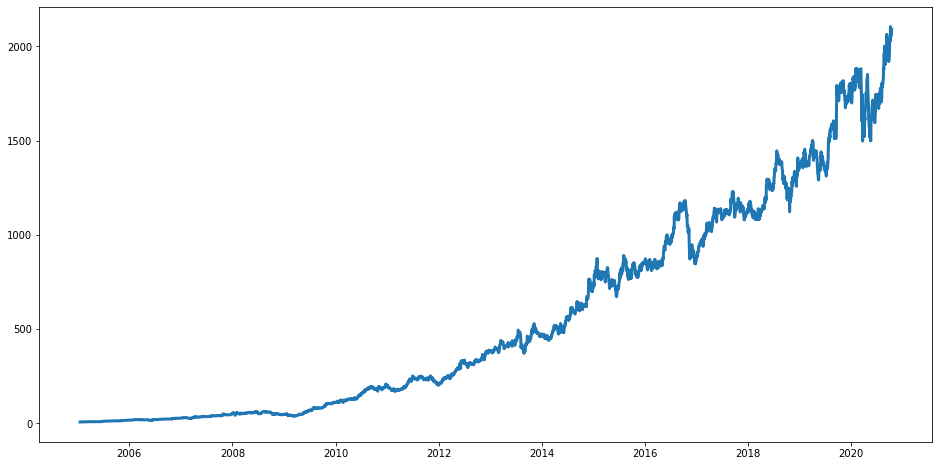

In [11]:
#Visualizing the close price
dates=np.array(df.index)
plt.figure(figsize=(16,8))
plt.plot(dates,df1.values, linewidth =3)
plt.show()

In [ ]:
### LSTM

In [12]:
# scaling the data in range (0,1)
from sklearn.preprocessing import MinMaxScaler
sc=MinMaxScaler(feature_range=(0,1))
df2=sc.fit_transform(np.array(df1).reshape(-1,1))
dfv2=sc.transform(np.array(dfv1).reshape(-1,1))

In [13]:
# Spliting the data set in training and test set 
#70% training data & 30% testing data

#training_size=int(len(df1)*0.7)
#test_size=len(df2)-training_size
#training_data,test_data = df2[0 : training_size, :], df2[training_size:len(df2),:1] 
# test data is  ==>  from 0.7*total to end

training_size=int(len(df))
training_data=df2[0:training_size,:]
test_size=(len(dfv))
test_data=dfv2[0:test_size,:]


In [14]:
training_size, test_size

(3878, 3876)

In [15]:
# Convert an array of values into a dataset matrix
#creating the training data set
def create_dataset(dataset, timestep):
    dataX,dataY=[] , []
    for i in range (len(dataset)-timestep-1):
        a=dataset[i:(i+timestep),0]                         #Ex - storing the values from 1 to 50
        dataX.append(a)
        dataY.append(dataset[i+timestep, 0])     #Ex - The output will be 51st day closing price
    return  np.array(dataX), np.array(dataY)

In [16]:
# creating train data and test data
timestep=100
X_train, Y_train =create_dataset(training_data, timestep)
print("X_train will start from "+str(timestep)+" to "+str(len(training_data)-timestep) )
X_test, Y_test = create_dataset(test_data, timestep)

# the test set will be ==>  from (total - timestep-1) to (total-1)

X_train will start from 100 to 3778


In [17]:
X_train.shape,Y_train.shape

((3777, 100), (3777,))

In [18]:
X_test.shape, Y_test.shape

((3775, 100), (3775,))

In [19]:
# reshaping the in 3D
# for LSTM we have input shape as (n_x, m, T_x) -- 3D
X_train=X_train.reshape(X_train.shape[0],X_train.shape[1],1)   #Shape ==> ((training_size - timestep-1),timestep, 1)
X_test=X_test.reshape(X_test.shape[0],X_test.shape[1],1)
print(X_train.shape)
print(X_test.shape)

(3777, 100, 1)
(3775, 100, 1)


In [20]:
### Creating stack LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Bidirectional

In [27]:
"""
TO UNDERSTAND THE LSTM INPUT/OUTPUT SHAPE ---
https://medium.com/@shivajbd/understanding-input-and-output-shape-in-lstm-keras-c501ee95c65e
"""

"""
TO UNDERSTAND RETURN SEQUENCES ---
https://www.dlology.com/blog/how-to-use-return_state-or-return_sequences-in-keras/

return sequences= True  gives the output for all the time steps
if return sequences = False returns the putput of the last timestep  -- RNN layer will only return the last hidden state output a<T>
"""

"""
STACKED LSTM ---
https://machinelearningmastery.com/stacked-long-short-term-memory-networks/
"""

model =Sequential()
model.add(Bidirectional(LSTM(50, return_sequences=True), input_shape=(X_train.shape[1],1)))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50, return_sequences=True)))
model.add(Bidirectional(LSTM(50)))

#model.add(LSTM(50, return_sequences= True,input_shape=(X_train.shape[1],1)))   #input shape ==>   100 timesteps and 1 feature
#model.add(LSTM(50, return_sequences= True))
##model.add(LSTM(50, return_sequences= True))
#model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss="mean_squared_error", optimizer="adam",metrics=[tf.keras.metrics.RootMeanSquaredError(
    name="root_mean_squared_error", dtype=None
)])

In [28]:
model.summary()

#Summary shows the output shape of an LSTM

#input shape of LSSTM ==> (Batch_size, timesteps, input_dims)
#output shape of LSTM ==> (Batch_size, timesteps, number of units)      -- When return sequences is True
#output shape of LSTM ==> (Batch_size,  number of units)      -- When return sequences is False

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 100, 100)          20800     
_________________________________________________________________
bidirectional_5 (Bidirection (None, 100, 100)          60400     
_________________________________________________________________
bidirectional_6 (Bidirection (None, 100, 100)          60400     
_________________________________________________________________
bidirectional_7 (Bidirection (None, 100)               60400     
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 202,101
Trainable params: 202,101
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#Loading previously trained model
model = tf.keras.models.load_model('/content/drive/My Drive/Colab Notebooks/Share Price prediction/Saved model/with bidirectional RNN - trained')


In [29]:
#Creating checkpoint to store weights
import os
#checkpoint_path = "D:\Python codes\Share price prediction\Trained weights\Bidirectional RNN/cp.ckpt"      #Run and save on computert
checkpoint_path = "/content/drive/My Drive/Colab Notebooks/Share Price prediction/Weights/cp.ckpt"                                                                 #Save on drive
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

In [30]:
history=model.fit(X_train,Y_train,validation_data =(X_test, Y_test), 
                    epochs =50, 
                    batch_size=32,
                   verbose=1,
                    callbacks=[cp_callback])

Epoch 1/50
118/119 [============================>.] - ETA: 0s - loss: 0.0051 - root_mean_squared_error: 0.0715
Epoch 00001: saving model to /content/drive/My Drive/Colab Notebooks/Share Price prediction/Weights/cp.ckpt
119/119 [==============================] - 9s 75ms/step - loss: 0.0051 - root_mean_squared_error: 0.0715 - val_loss: 5.2730e-04 - val_root_mean_squared_error: 0.0230
Epoch 2/50
119/119 [==============================] - ETA: 0s - loss: 4.4767e-04 - root_mean_squared_error: 0.0212
Epoch 00002: saving model to /content/drive/My Drive/Colab Notebooks/Share Price prediction/Weights/cp.ckpt
119/119 [==============================] - 6s 51ms/step - loss: 4.4767e-04 - root_mean_squared_error: 0.0212 - val_loss: 0.0016 - val_root_mean_squared_error: 0.0403
Epoch 3/50
118/119 [============================>.] - ETA: 0s - loss: 4.8787e-04 - root_mean_squared_error: 0.0221
Epoch 00003: saving model to /content/drive/My Drive/Colab Notebooks/Share Price prediction/Weights/cp.ckpt
119

In [ ]:
# Save the entire model as a SavedModel.
!mkdir -p saved_model
model.save('/content/drive/My Drive/Colab Notebooks/Share Price prediction/Saved model/with bidirectional RNN - trained') 

#Models saved in this format can be restored using
# tf.keras.models.load_model

'''
new_model = tf.keras.models.load_model('\Path')

# Check its architecture
new_model.summary()
'''

INFO:tensorflow:Assets written to: /content/drive/My Drive/Colab Notebooks/Share Price prediction/Saved model/with bidirectional RNN - trained/assets


"\nnew_model = tf.keras.models.load_model('\\Path')\n\n# Check its architecture\nnew_model.summary()\n"

In [31]:
'''
# Create and train a new model instance.
model = create_model()
model.fit(train_images, train_labels, epochs=5)
'''
# Save the entire model to a HDF5 file.
# The '.h5' extension indicates that the model should be saved to HDF5.
model.save('my_model.h5') 
'''
# Recreate the exact same model, including its weights and the optimizer
new_model = tf.keras.models.load_model('my_model.h5')

# Show the model architecture
new_model.summary()
'''

"\n# Recreate the exact same model, including its weights and the optimizer\nnew_model = tf.keras.models.load_model('my_model.h5')\n\n# Show the model architecture\nnew_model.summary()\n"

In [ ]:
# Loads the weights
model.load_weights(checkpoint_path)

In [32]:
# Prediction
train_predict=model.predict(X_train)
test_predict= model.predict(X_test)

In [33]:
# Scale back the predictions to original values (Initally we had scaled down to range 0-1)
train_predict =sc.inverse_transform(train_predict)
test_predict =sc.inverse_transform(test_predict)

In [34]:
## Performance Metrics (RMSE)
import math 
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(sc.inverse_transform(Y_train.reshape(-1,1)),train_predict))

17.28400068466778

In [35]:
## Test data RMSE
math.sqrt(mean_squared_error(sc.inverse_transform(Y_test.reshape(-1,1)),test_predict))

18.46552267610302

In [36]:
#len(train_predict)
dates=np.array(df.index)

train end at  3877
test start at 3978
test end at 3877
Test length -101
The shape of X_test 3775


<Figure size 1152x432 with 0 Axes>

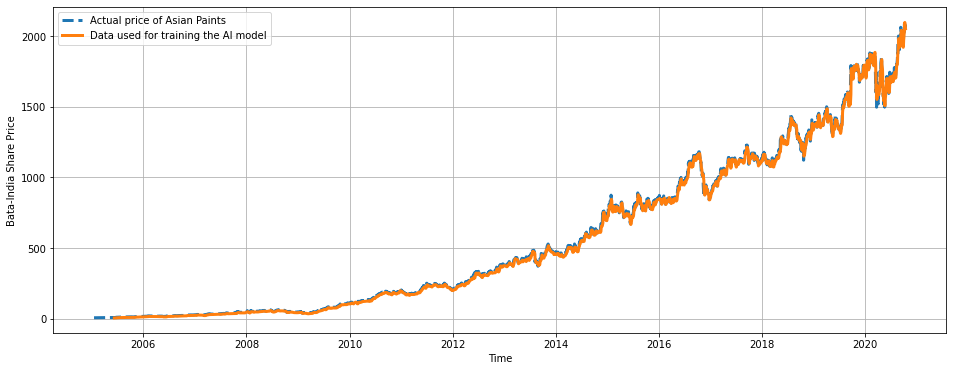

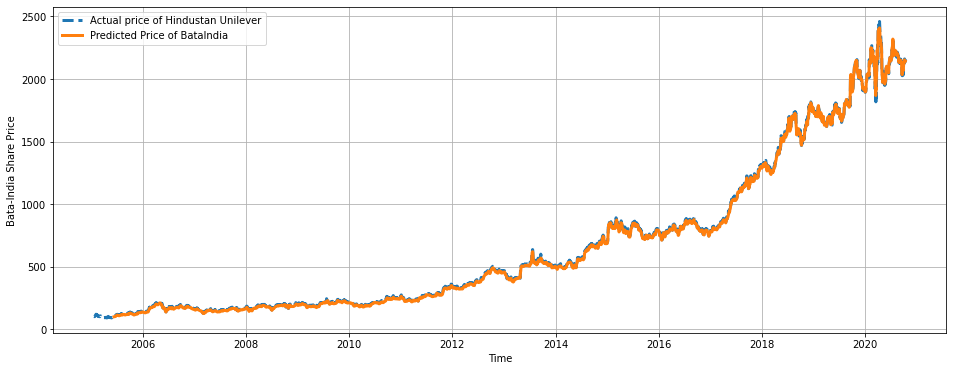

In [37]:
## Plotting
plt.figure(figsize=(16,6))
look_back=100
# Shift train predictions for plotting
trainplot=np.empty_like(df2)
trainplot[:, :] =np.nan
trainplot[look_back:len(train_predict)+look_back, :] = train_predict   
print("train end at ",len(train_predict)+look_back)

# Shift test predictions for plotting
testplot=np.empty_like(df2)
testplot[:, :] =np.nan

print("test start at",len(train_predict)+2*look_back+1)
print("test end at",len(df2)-1)
print("Test length",len(df2)-1-(len(train_predict)+2*look_back+1))
print("The shape of X_test",X_test.shape[0])

testplot[look_back:len(test_predict)+look_back, :] = test_predict     #For two share
#testplot[len(train_predict)+2*look_back+1:len(df2)-1, :] = test_predict        
#2*look_back covers the previous the previous 100 timesteps data included in training/testing the model
# For testing the data will come from (len(train_predict+look_back) : len(train_predict+2*look_back) ) 
#==> the first prediction will come at [len(train_predict)+2*look_back+1]

# Plotting baseline and predictions
#%matplotlib tk
#%matplotlib qt
plt.figure(figsize=(16,6))
plt.plot(dates,sc.inverse_transform(df2), linestyle='dashed',linewidth=3,label="Actual price of Asian Paints")
plt.plot(dates,trainplot,linewidth=3,label="Data used for training the AI model")
#plt.plot(dates,testplot,linewidth=3, label ="Predicted Price of BataIndia")
plt.xlabel('Time')
plt.ylabel('Bata-India Share Price')
plt.legend()
plt.grid()
plt.show()

plt.figure(figsize=(16,6))
plt.plot(dates[2:],sc.inverse_transform(dfv2), linestyle='dashed',linewidth=3,label="Actual price of Hindustan Unilever")
plt.plot(dates,testplot,linewidth=3, label ="Predicted Price of BataIndia")
plt.xlabel('Time')
plt.ylabel('Bata-India Share Price')
plt.legend()
plt.grid()
plt.show()

In [ ]:
#test_predict

In [ ]:
len(test_data) 
# Have last day as 27sept -->  Taking prev 100 days data   to get --> 28th sept

3876

In [ ]:
x_input=training_data[len(training_data)-100:].reshape(-1,1) #Taking previous day 100 data
x_input.shape

(100, 1)

In [ ]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [ ]:
x_input=x_input.reshape((1,n_steps,1))
yhat=model.predict(x_input,verbose=0)
yhat[0].tolist()
temp_input.extend(yhat[0].tolist())
temp_input
len(temp_input)

3

In [ ]:
temp_input

[0.7797886529855602, 0.9901625514030457, 0.9901625514030457]

In [ ]:
for i in range(len(temp_input)):
  temp_input[i]=temp_input[i].tolist()

In [ ]:

from numpy import array
lst_output=[] #empty list
n_steps =100
i=0
while (i<30):
    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])   #gets prev 100 day data from latest(updated) temp_input
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input=x_input.reshape((1,n_steps,1))
        
        #print(x_input)
        yhat=model.predict(x_input,verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input=x_input.reshape((1,n_steps,1))
        yhat=model.predict(x_input,verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        %debug
        lst_output.extend(yhat.tolist())
        i=i+1
        
        
print(lst_output)

[0.97331727]
2
> <ipython-input-4-0cefd78f27f4>(1)<module>()
----> 1 temp_input=list(x_input)
      2 temp_input=temp_input[0].tolist()

ipdb> temp_input
[0.7797886529855602, 0.9733172655105591]
ipdb> temp_input
[0.7797886529855602, 0.9733172655105591]
ipdb> 
[0.7797886529855602, 0.9733172655105591]
ipdb> 
[0.7797886529855602, 0.9733172655105591]
--KeyboardInterrupt--
ipdb> c
[0.97331727]
3
> <ipython-input-4-0cefd78f27f4>(1)<module>()
----> 1 temp_input=list(x_input)
      2 temp_input=temp_input[0].tolist()

ipdb> c
[0.97331727]
4
> <ipython-input-4-0cefd78f27f4>(1)<module>()
----> 1 temp_input=list(x_input)
      2 temp_input=temp_input[0].tolist()

ipdb> 
[0.97331727]
5
> <ipython-input-4-0cefd78f27f4>(1)<module>()
----> 1 temp_input=list(x_input)
      2 temp_input=temp_input[0].tolist()



In [ ]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [ ]:
len(df2) #df2 is scaled dataframe

3878

In [ ]:
df3=df2.tolist()
df3.extend(lst_output) # adding the latest output to the existing data

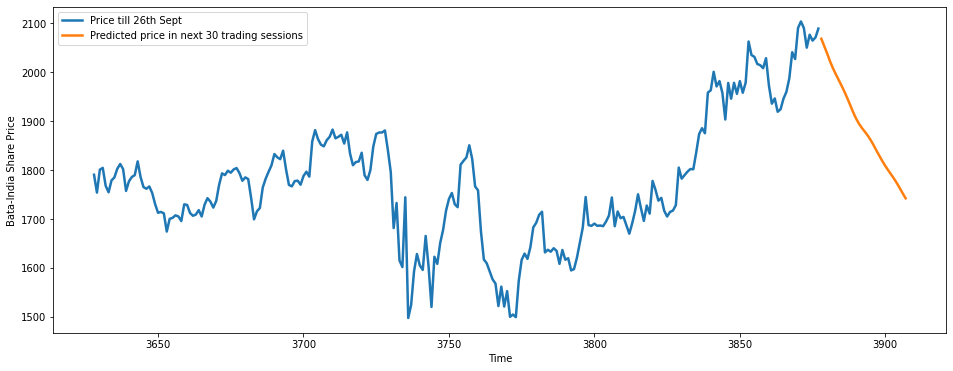

In [ ]:
plt.figure(figsize=(16,6))

timeframe_prev =list(range(len(df2)-250, len(df2)))
plt.plot(timeframe_prev,sc.inverse_transform(df2[len(df2)-250:]), label="Price till 26th Sept",linewidth=2.5) 

timeframe =list(range(len(df2), len(df2)+30))
plt.plot(timeframe,sc.inverse_transform(lst_output), label="Predicted price in next 30 trading sessions",linewidth=2.5)

plt.xlabel('Time')
plt.ylabel('Bata-India Share Price')
plt.legend()
plt.show()

In [ ]:
sc.inverse_transform(lst_output)

array([[2068.65099682],
       [2053.68056755],
       [2038.76436901],
       [2022.51814318],
       [2008.27495544],
       [1995.81688325],
       [1984.01857655],
       [1972.18153363],
       [1959.66198328],
       [1946.1622813 ],
       [1931.92309213],
       [1917.57969001],
       [1904.82772227],
       [1894.24323417],
       [1885.78499036],
       [1878.1816927 ],
       [1870.21302489],
       [1861.08576887],
       [1850.60899248],
       [1839.38298239],
       [1828.68178577],
       [1818.1852664 ],
       [1808.38824842],
       [1799.49890784],
       [1791.02466972],
       [1782.37024564],
       [1772.95509194],
       [1762.74272158],
       [1752.20396723],
       [1742.1757814 ]])

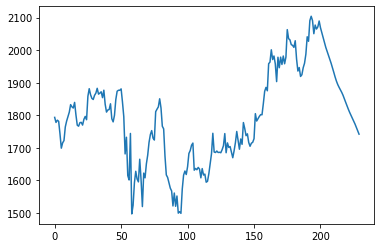

In [ ]:
df3=df2.tolist()
df3.extend(lst_output)
plt.plot(sc.inverse_transform(df3[len(df2)-200:]))

In [ ]:
from .colab import drive
drive.mount("/content/gdrive")

ModuleNotFoundError: ignored

In [ ]:
 model_save_name="share price prediction bidirectional RNN weights"
path = F"/content/gdrive/My Drive/{model_save_name}" 
torch.save(model.state_dict(), path)
  

NameError: ignored